In [32]:
!pip install emoji
!pip install googletrans==3.1.0a0
import pandas as pd
import numpy as np
import re
import json
import chardet
import nltk
import spacy
import emoji
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from googletrans import Translator
from tqdm import tqdm
import os

In [33]:


# Download necessary NLTK resources
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('vader_lexicon')
except LookupError:
    nltk.download("stopwords")
    nltk.download("punkt")
    nltk.download("vader_lexicon")
    nltk.download('punkt_tab')

# Load spaCy model
try:
    nlp = spacy.load("en_core_web_sm")
except:
    print("Installing spaCy model...")
    import subprocess
    subprocess.call(["python", "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm")

# Initialize tools
translator = Translator()
sentiment_analyzer = SentimentIntensityAnalyzer()

# Define provinces and locations
locations = {
    "Western Province": {
        "Colombo": ["GalleFace", "Gangarama Temple", "National Museum", "Viharamahadevi Park", "Independence Square",
                    "Lotus Tower", "Pettah Market", "Beira Lake", "Diyatha Uyana", "Colombo Port City",
                    "Old Parliament Building", "Jami Ul-Alfar Mosque"],
        "Negombo": ["Negombo Beach", "Dutch Canal", "Negombo Fish Market", "St. Mary's Church", "Angurukaramulla Temple",
                    "Negombo Lagoon", "Muthurajawela Marsh", "Hamilton Canal"],
        "Kalutara": ["Kalutara Bodhiya", "Richmond Castle", "Brief Garden", "Pahiyangala Cave", "Kalutara Beach"]
    },
    "Central Province": {
        "Kandy": [
          "Temple of the Tooth Relic", "Peradeniya Botanical Gardens", "Kandy Lake",
          "Bahirawakanda Vihara Buddha Statue", "Udawatta Kele Sanctuary", "Ceylon Tea Museum",
          "Royal Palace of Kandy", "Kandyan Cultural Centre"
        ],
        "Nuwara Eliya": [
          "Horton Plains", "Gregory Lake", "Lover's Leap Waterfall",
          "Pedro Tea Estate", "Hakgala Botanical Garden", "Ambewela Farm", "Moon Plains",
          "Victoria Park", "Seetha Amman Temple"
        ],
        "Matale": [
          "Sigiriya", "Dambulla Cave Temple", "Popham's Arboretum",
          "Nalanda Gedige", "Aluvihara Rock Temple", "Spice Gardens", "Knuckles Mountain Range"
        ]
    },
    "Southern Province": {
        "Galle": [
          "Galle Fort", "Japanese Peace Pagoda", "Unawatuna Beach", "Jungle Beach",
          "Dutch Reformed Church", "Maritime Museum", "Koggala Lake", "Sea Turtle Hatchery"
        ],
        "Mirissa": [
          "Mirissa Beach", "Parrot Rock", "Secret Beach", "Whale Watching Tours"
        ],
        "Tangalle": [
          "Tangalle Beach", "Rekawa Turtle Conservation", "Mulkirigala Rock Temple", "Hummanaya Blowhole"
        ],
        "Hambantota": [
          "Yala National Park", "Bundala National Park", "Ridiyagama Safari Park", "Dry Zone Botanical Gardens"
        ]
    },
    "Eastern Province": {
        "Trincomalee": [
          "Nilaveli Beach", "Pigeon Island National Park", "Koneswaram Temple", "Fort Frederick",
          "Marble Beach", "Hot Water Wells", "Uppuveli Beach"
        ],
        "Arugam Bay": [
          "Main Surf Point", "Elephant Rock", "Crocodile Rock", "Muhudu Maha Viharaya", "Whiskey Point"
        ],
        "Batticaloa": [
          "Batticaloa Lighthouse", "Batticaloa Lagoon", "Dutch Fort", "Pasikudah Beach"
        ]
    },
    "Northern Province": {
        "Jaffna": [
          "Nallur Kandaswamy Temple", "Jaffna Fort", "Nagadeepa Vihara", "Casuarina Beach",
          "Keerimalai Hot Springs", "Jaffna Library", "Delft Island"
        ],
        "Mannar": [
          "Adam's Bridge (Ram Setu)", "Thiruketheeswaram Temple", "Mannar Fort", "Baobab Tree"
        ]
    },
    "North Central Province": {
        "Anuradhapura": [
          "Ruwanwelisaya Stupa", "Sri Maha Bodhi", "Jetavanaramaya", "Mihintale",
          "Isurumuniya Temple", "Kuttam Pokuna", "Abhayagiri Monastery"
        ],
        "Polonnaruwa": [
          "Gal Vihara", "Vatadage", "Rankoth Vehera", "Parakrama Samudra", "Lankathilaka Viharaya", "Nelum Pokuna"
        ],
        "Sigiriya": [
          "Sigiriya Rock Fortress", "Pidurangala Rock", "Hiriwadunna Village Safari"
        ]
    },
    "Uva Province": {
        "Ella": [
          "Nine Arches Bridge", "Little Adam's Peak", "Ravana Falls", "Ella Rock", "Diyaluma Falls",
          "Demodara Loop", "Tea Factory Tours"
        ],
        "Badulla": [
          "Dunhinda Falls", "Muthiyangana Temple", "Bogoda Wooden Bridge", "St. Mark's Church"
        ]
    },
    "Sabaragamuwa Province": {
        "Ratnapura": [
          "Gemmological Museum", "Bopath Ella Waterfall", "Udawalawe National Park",
          "Sinharaja Rainforest", "Saman Devalaya"
        ],
        "Kitulgala": [
          "White Water Rafting", "Belilena Cave", "Makandawa Rainforest"
        ]
    }
}

# Flatten province city mapping for easier reference
province_city_mapping = {}
city_province_mapping = {}
all_cities = []
all_locations = []
all_provinces = list(locations.keys())

for province, cities in locations.items():
    province_city_mapping[province] = list(cities.keys())
    for city, attractions in cities.items():
        city_province_mapping[city] = province
        all_cities.append(city)
        for attraction in attractions:
            all_locations.append(attraction)

# Define aspects for aspect-based sentiment analysis
aspects = {
    "attractions": ["beach", "temple", "heritage", "view", "scenery", "wildlife", "hiking", "mountain", "sigiriya",
                    "ella", "adams peak", "forest", "botanical garden", "park", "waterfall", "hot spring", "lighthouse",
                    "rock fortress", "tea plantation", "river safari", "cave temple", "historical site", "archaeology",
                    "national park", "buddhist site", "hindu temple", "ancient ruins", "lake", "sunrise", "sunset",
                    "bird watching", "marine life", "snorkeling", "diving", "reef", "whale watching", "dolphin tour",
                    "cultural site", "museum", "galle fort", "world heritage", "yala", "horton plains", "pinnawala",
                    "wilpattu", "nine arches", "udawalawe", "paintings", "statues", "buddha"],
    "accommodation": [
        "hotel", "room", "stay", "resort", "hostel", "airbnb", "guesthouse", "villa", "bungalow", "motel",
        "homestay", "eco lodge", "budget stay", "luxury stay", "suite", "cottage", "rental house", "dormitory",
        "beach resort", "mountain lodge", "riverside villa", "private room", "shared dorm", "heritage hotel",
        "treehouse", "spa resort", "wellness retreat", "yoga retreat", "boutique hotel", "5-star hotel",
        "business hotel", "family stay", "pet-friendly hotel", "host family", "holiday rental", "farm stay"
    ],
    "accessibility": [
        "road", "transportation", "traffic", "airport", "bus", "train", "taxi", "tuk-tuk", "cab", "car rental",
        "ferry", "domestic flight", "public transport", "bike rental", "walking tour", "shuttle service",
        "railway", "expressway", "highway", "bypass", "road safety", "bus station", "train station",
        "port", "cruise terminal", "bike lane", "footpath", "cycle track", "navigation", "google maps",
        "road condition", "construction", "airport transfer", "long-distance travel", "metro", "subway"
    ],
    "food": [
        "restaurant", "food", "meal", "cuisine", "breakfast", "dining", "buffet", "lunch", "dinner", "snack",
        "dessert", "bakery", "tea", "coffee", "juice", "cocktail", "local food", "rice and curry",
        "seafood", "hoppers", "string hoppers", "kottu", "roti", "spices", "vegetarian", "vegan",
        "street food", "market food", "fine dining", "fast food", "homemade food", "family restaurant",
        "beachside cafe", "rooftop restaurant", "tea plantation tour", "organic food", "tropical fruits",
        "banana leaf meal", "grilled fish", "tandoori", "samosa", "biryani", "lamprais", "curd and treacle"
    ],
    "safety": [
        "crime", "theft", "scam", "harassment", "accident", "security", "police", "safety guide",
        "emergency", "medical assistance", "hospital", "ambulance", "insurance", "protest", "violence",
        "political unrest", "disaster", "weather warning", "tsunami", "earthquake", "cyclone", "flood",
        "pickpocket", "fraud", "corruption", "dangerous area", "safe travel", "risk", "criminal activity",
        "night safety", "beach safety", "road safety", "wildlife safety", "water safety", "fire hazard",
        "first aid", "self-defense", "travel warning", "restricted area", "health alert", "terrorism alert"
    ],
    "customer_service": [
        "staff", "hospitality", "service", "friendly", "rude", "helpful", "attitude", "receptionist",
        "cleaning staff", "waiter", "tour guide", "host", "driver", "concierge", "professionalism",
        "customer support", "complaint", "feedback", "smiling", "politeness", "courteous", "quick response",
        "slow service", "welcoming", "check-in", "check-out", "assistance", "language barrier",
        "local guide", "tour operator", "airport assistance", "reservation", "booking help", "support desk"
    ],
    "pricing": [
        "cost", "expensive", "affordable", "overpriced", "cheap", "value", "money", "budget", "discount",
        "promotion", "deal", "package", "rate", "fare", "entrance fee", "transport cost", "food price",
        "hotel price", "luxury", "all-inclusive", "extra charges", "tax", "hidden cost", "bargain",
        "economic", "reasonable", "service charge", "credit card", "exchange rate", "currency", "money exchange"
    ],
    "nightlife": [
        "bar", "pub", "club", "casino", "party", "music", "DJ", "live band", "karaoke", "cocktail", "alcohol",
        "dance", "nightclub", "rooftop bar", "whiskey", "beer", "night market", "midnight snack",
        "festival", "pool party", "hookah", "beach party", "fire show", "sunset drinks", "wine tasting"
    ],
    "shopping": [
        "shopping", "market", "souvenirs", "mall", "crafts", "textile", "gemstones", "jewelry",
        "handmade", "local market", "bazaar", "boutique", "fashion", "clothing", "grocery", "supermarket",
        "street shopping", "electronics", "duty-free", "bargain", "art", "home decor", "curio shop",
        "cinnamon", "tea", "spice shop", "batik", "silk", "antiques", "carpets", "perfume"
    ],
    "culture": [
        "history", "tradition", "locals", "festival", "dance", "culture", "art", "ritual", "heritage",
        "religion", "monastery", "pilgrimage", "temple ceremony", "drumming", "fire dance", "storytelling",
        "folklore", "craftsmanship", "pottery", "wood carving", "brassware", "mask making", "buddhism",
        "hinduism", "architecture", "historical monument", "colonial history", "tea culture", "traditional music"
    ]
}

# Flatten all aspect keywords for easier searching
all_aspect_keywords = []
aspect_category_mapping = {}
for category, keywords in aspects.items():
    for keyword in keywords:
        all_aspect_keywords.append(keyword)
        aspect_category_mapping[keyword] = category

# Function to remove emojis from text
def remove_emojis(text):
    return emoji.replace_emoji(text, replace="")

# Function to preprocess text
def preprocess_text(text):
    if pd.isna(text):
        return ""

    text = str(text).lower()
    text = remove_emojis(text)

    # Detect language and translate if necessary
    try:
        detected_lang = translator.detect(text).lang
        if detected_lang != "en":
            text = translator.translate(text, dest="en").text
    except:
        # If translation fails, continue with the original text
        pass

    # Tokenization
    words = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    words = [word for word in words if word.isalnum() and word not in stop_words]

    return " ".join(words)

# Function to detect file encoding
def detect_file_encoding(file_path):
    with open(file_path, 'rb') as rawdata:
        result = chardet.detect(rawdata.read(1000000))
    return result['encoding']

# Improved function to detect province directly and from cities/locations
def detect_province(text):
    text = text.lower()

    # Direct mention of province
    for province in all_provinces:
        if province.lower() in text:
            return province

    # Check for city mentions and map to province
    for city in all_cities:
        if city.lower() in text:
            return city_province_mapping[city]

    # Use spaCy NER for better location detection
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ in ["GPE", "LOC"]:
            # Check if this entity matches any of our known cities
            for city in all_cities:
                if ent.text.lower() in city.lower() or city.lower() in ent.text.lower():
                    return city_province_mapping[city]

    # If no direct matches, try to find locations and map them to cities and provinces
    for province, cities in locations.items():
        for city, attractions in cities.items():
            for attraction in attractions:
                if attraction.lower() in text:
                    return province

    return None

# Enhanced function to detect specific locations from review
def detect_locations(review):
    review_lower = review.lower()
    detected_locations = []

    # Direct matching for known locations
    for province, cities in locations.items():
        for city, attractions in cities.items():
            # Add city if mentioned
            if city.lower() in review_lower:
                detected_locations.append(city)

            # Add attractions if mentioned
            for attraction in attractions:
                if attraction.lower() in review_lower:
                    detected_locations.append(attraction)

    # Use spaCy NER for better location detection
    doc = nlp(review)
    for ent in doc.ents:
        if ent.label_ in ["GPE", "LOC", "FAC"]:
            # Check if this entity is a new location (not already detected)
            location_name = ent.text.strip()
            if location_name and location_name.lower() not in [loc.lower() for loc in detected_locations]:
                # Verify it's not a false positive (too short or too common)
                if len(location_name) > 3 and location_name.lower() not in ["here", "there", "place", "area"]:
                    detected_locations.append(location_name)

    # Remove duplicates while preserving order
    unique_locations = []
    for loc in detected_locations:
        if loc not in unique_locations:
            unique_locations.append(loc)

    return unique_locations

# Enhanced function to detect aspects in a review using NLP and pattern matching
def detect_aspects(review):
    review_lower = review.lower()
    found_aspects = []

    # Direct keyword matching from our predefined aspects
    for keyword in all_aspect_keywords:
        if keyword in review_lower.split() or f" {keyword} " in f" {review_lower} ":
            found_aspects.append(keyword)

    # Use spaCy for additional aspect extraction
    doc = nlp(review)

    # Extract noun phrases as potential aspects
    for chunk in doc.noun_chunks:
        chunk_text = chunk.text.lower()
        # Check if this noun phrase contains any of our aspect keywords
        for keyword in all_aspect_keywords:
            if keyword in chunk_text and keyword not in found_aspects:
                found_aspects.append(keyword)

    # Look for adjective-noun combinations that might be aspects
    for token in doc:
        if token.pos_ == "ADJ" and token.head.pos_ == "NOUN":
            compound = f"{token.text} {token.head.text}".lower()
            # Check if this compound matches any of our aspects
            for keyword in all_aspect_keywords:
                if keyword in compound and keyword not in found_aspects:
                    found_aspects.append(keyword)

    # Remove duplicates
    unique_aspects = list(set(found_aspects))

    return unique_aspects

# Advanced function to map aspects to locations based on proximity in text
def map_aspects_to_locations(review, aspects, locations):
    if not aspects or not locations:
        return {}

    mapping = {}

    # Process with spaCy for sentence segmentation
    doc = nlp(review)
    sentences = list(doc.sents)

    # Initialize mapping dictionary
    for aspect in aspects:
        mapping[aspect] = []

    # First pass: find aspects and locations in the same sentence
    for sentence in sentences:
        sentence_text = sentence.text.lower()
        sentence_aspects = [aspect for aspect in aspects if aspect.lower() in sentence_text]
        sentence_locations = [location for location in locations if location.lower() in sentence_text]

        # Map aspects to locations in the same sentence
        for aspect in sentence_aspects:
            for location in sentence_locations:
                if location not in mapping[aspect]:
                    mapping[aspect].append(location)

    # Second pass: for aspects with no locations, try to find closest location
    for aspect in aspects:
        if not mapping[aspect]:
            # Find positions of this aspect in the text
            aspect_positions = [match.start() for match in re.finditer(r'\b' + re.escape(aspect.lower()) + r'\b', review.lower())]
            if aspect_positions:
                # Find the closest location based on character distance
                closest_location = None
                min_distance = float('inf')

                for location in locations:
                    location_positions = [match.start() for match in re.finditer(r'\b' + re.escape(location.lower()) + r'\b', review.lower())]
                    for loc_pos in location_positions:
                        for asp_pos in aspect_positions:
                            distance = abs(loc_pos - asp_pos)
                            if distance < min_distance:
                                min_distance = distance
                                closest_location = location

                if closest_location and min_distance < 200:  # Only use if reasonably close
                    mapping[aspect].append(closest_location)

    # Third pass: for aspects that still have no locations, assign all locations
    for aspect in aspects:
        if not mapping[aspect] and locations:
            mapping[aspect] = locations.copy()

    return mapping

# Function to classify sentiment with enhanced accuracy
def get_sentiment(text):
    # Use VADER for sentiment analysis
    scores = sentiment_analyzer.polarity_scores(text)
    compound_score = scores["compound"]

    # Refine sentiment analysis with contextual cues
    if "terrible" in text.lower() or "awful" in text.lower() or "horrible" in text.lower():
        compound_score -= 0.2
    if "amazing" in text.lower() or "excellent" in text.lower() or "wonderful" in text.lower():
        compound_score += 0.2

    # Ensure score is within -1 to 1 range
    compound_score = max(-1, min(1, compound_score))

    # Classify sentiment
    if compound_score >= 0.05:
        return compound_score, "Positive"
    elif compound_score <= -0.05:
        return compound_score, "Negative"
    else:
        return compound_score, "Neutral"

# Function to process a single review
def process_review(review):
    if pd.isna(review) or not isinstance(review, str) or len(review.strip()) < 10:
        return {
            "Review": "",
            "Extracted Province": "",
            "Extracted Locations": [],
            "Extracted Aspects": [],
            "Aspect-Location Mapping": {},
            "Sentiment Score": 0,
            "Sentiment Label": "Neutral"
        }

    # Preprocess the review text for analysis
    processed_text = preprocess_text(review)

    # Extract province
    province = detect_province(review)

    # Extract locations
    extracted_locations = detect_locations(review)

    # Extract aspects
    extracted_aspects = detect_aspects(review)

    # Map aspects to locations
    aspect_location_mapping = map_aspects_to_locations(review, extracted_aspects, extracted_locations)

    # Get sentiment
    sentiment_score, sentiment_label = get_sentiment(review)

    return {
        "Review": review,
        "Extracted Province": province if province else "",
        "Extracted Locations": extracted_locations,
        "Extracted Aspects": extracted_aspects,
        "Aspect-Location Mapping": aspect_location_mapping,
        "Sentiment Score": sentiment_score,
        "Sentiment Label": sentiment_label
    }

# Function to identify the review column in the dataframe
def identify_review_column(df):
    possible_columns = ['review', 'reviews', 'comment', 'comments', 'feedback', 'text', 'content']

    # First try: exact match with known review column names
    for col in df.columns:
        if col.lower() in possible_columns:
            return col

    # Second try: partial match with column names
    for col in df.columns:
        for term in possible_columns:
            if term in col.lower():
                return col

    # Third try: check data types and length of content
    text_columns = df.select_dtypes(include=['object']).columns
    if len(text_columns) > 0:
        # Calculate average text length for each column
        avg_lengths = {}
        for col in text_columns:
            sample = df[col].dropna().astype(str).head(10)
            if len(sample) > 0:
                avg_lengths[col] = sum(len(str(x)) for x in sample) / len(sample)

        if avg_lengths:
            # Use the column with the longest average text
            return max(avg_lengths, key=avg_lengths.get)

    # Last resort: use the first column
    return df.columns[0]

def main():
    # File paths
    input_csv = "/content/Total Tourism Reviews.csv"  # Change this to your input file path
    output_csv = "processed_reviews.csv"

    # Check if input file exists
    if not os.path.exists(input_csv):
        print(f"Input file {input_csv} not found. Please provide a valid CSV file path.")
        return

    # Detect file encoding
    try:
        encoding = detect_file_encoding(input_csv)
        print(f"Detected encoding: {encoding}")
    except Exception as e:
        print(f"Error detecting encoding: {e}")
        encoding = 'utf-8'  # Default fallback

    # Read the CSV file with multiple attempts
    df = None
    try:
        # First, try to read with automatic header detection
        df = pd.read_csv(input_csv, encoding=encoding, engine='python')
    except Exception as e:
        print(f"First attempt error: {e}")
        try:
            # Try with explicit header row
            df = pd.read_csv(input_csv, encoding=encoding, header=0)
        except Exception as e:
            print(f"Second attempt error: {e}")
            try:
                # Try without header
                df = pd.read_csv(input_csv, encoding=encoding, header=None)
                # Rename columns
                df.columns = [f'col_{i}' for i in range(len(df.columns))]
            except Exception as e:
                print(f"Third attempt error: {e}")
                print("Could not read the file. Please check the file format.")
                return

    if df is None or len(df) == 0:
        print("No data found in the file.")
        return

    print(f"Successfully loaded CSV with {len(df)} rows.")
    print(f"Columns in dataframe: {df.columns.tolist()}")

    # Identify the review column
    review_column = identify_review_column(df)
    print(f"Using '{review_column}' as the review column.")

    # Process each review with progress bar
    results = []
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing reviews"):
        review_text = str(row[review_column]) if not pd.isna(row[review_column]) else ""
        processed = process_review(review_text)
        results.append(processed)

    # Create output dataframe
    output_df = pd.DataFrame(results)

    # Convert lists and dictionaries to strings for CSV output
    for col in ['Extracted Locations', 'Extracted Aspects', 'Aspect-Location Mapping']:
        output_df[col] = output_df[col].apply(lambda x: json.dumps(x))

    # Save to CSV
    output_df.to_csv(output_csv, index=False, quoting=1)
    print(f"Processing complete. Results saved to {output_csv}")
    print(f"Processed {len(output_df)} reviews.")

    return output_df

if __name__ == "__main__":
    main()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Detected encoding: Windows-1252
Successfully loaded CSV with 999 rows.
Columns in dataframe: ['Being responsible for Sri Lanka market and being there almost once in every 15-20 days has given me great insight into this island nation .. and this is from my experience with interactions and office and other wise.']
Using 'Being responsible for Sri Lanka market and being there almost once in every 15-20 days has given me great insight into this island nation .. and this is from my experience with interactions and office and other wise.' as the review column.


Processing reviews: 100%|██████████| 999/999 [02:27<00:00,  6.76it/s]

Processing complete. Results saved to processed_reviews.csv
Processed 999 reviews.


In [34]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
from wordcloud import WordCloud
import plotly.graph_objects as go

# Load the processed data
df = pd.read_csv('/content/processed_reviews_Total.csv')

# Convert JSON strings back to Python objects
df['Extracted Locations'] = df['Extracted Locations'].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
df['Extracted Aspects'] = df['Extracted Aspects'].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
df['Aspect-Location Mapping'] = df['Aspect-Location Mapping'].apply(lambda x: json.loads(x) if isinstance(x, str) else x)

# Sentiment by Province
def plot_sentiment_by_province():
    # Group by province and calculate average sentiment
    province_sentiment = df[df['Extracted Province'] != ''].groupby('Extracted Province')['Sentiment Score'].agg(['mean', 'count']).reset_index()
    province_sentiment = province_sentiment.sort_values('mean', ascending=False)

    # Create interactive bar chart
    fig = px.bar(
        province_sentiment,
        x='Extracted Province',
        y='mean',
        color='mean',
        color_continuous_scale='RdBu',
        labels={'mean': 'Average Sentiment', 'Extracted Province': 'Province', 'count': 'Number of Reviews'},
        title='Average Sentiment Score by Province for Google Reviews',
        hover_data=['count']
    )

    fig.update_layout(
        xaxis_title='Province',
        yaxis_title='Average Sentiment Score',
        coloraxis_colorbar_title='Sentiment<br>Score',
        height=600,
        width=900
    )

    # Add a horizontal line at sentiment = 0
    fig.add_shape(
        type="line",
        x0=-0.5,
        y0=0,
        x1=len(province_sentiment)-0.5,
        y1=0,
        line=dict(color="black", width=1, dash="dash")
    )

    return fig

# Call the function to generate the plot
sentiment_by_province_fig = plot_sentiment_by_province()
sentiment_by_province_fig.show()

In [35]:
# Function to create an aspect-based sentiment heatmap
def plot_aspect_sentiment_heatmap():
    # Extract all aspects and calculate sentiment for each
    aspect_sentiments = {}
    aspect_counts = {}

    # Define the aspect categories based on your mapping
    aspect_categories = {
        "attractions": ["beach", "temple", "heritage", "view", "scenery", "wildlife", "hiking", "mountain", "sigiriya",
                    "ella", "adams peak", "forest", "botanical garden", "park", "waterfall", "hot spring", "lighthouse"],
        "accommodation": ["hotel", "room", "stay", "resort", "hostel", "airbnb", "guesthouse", "villa", "bungalow"],
        "accessibility": ["road", "transportation", "traffic", "airport", "bus", "train", "taxi", "tuk-tuk", "cab"],
        "food": ["restaurant", "food", "meal", "cuisine", "breakfast", "dining", "buffet", "lunch", "dinner"],
        "safety": ["crime", "theft", "scam", "harassment", "accident", "security", "police"],
        "customer_service": ["staff", "hospitality", "service", "friendly", "rude", "helpful", "attitude"],
        "pricing": ["cost", "expensive", "affordable", "overpriced", "cheap", "value", "money", "budget"],
        "nightlife": ["bar", "pub", "club", "casino", "party", "music", "DJ", "live band", "karaoke"],
        "shopping": ["shopping", "market", "souvenirs", "mall", "crafts", "textile", "gemstones", "jewelry"],
        "culture": ["history", "tradition", "locals", "festival", "dance", "culture", "art", "ritual", "heritage"]
    }

    # Reverse mapping from aspect keyword to category
    aspect_to_category = {}
    for category, aspects in aspect_categories.items():
        for aspect in aspects:
            aspect_to_category[aspect] = category

    # Gather sentiment data by aspect category
    category_sentiments = {category: [] for category in aspect_categories}
    category_counts = {category: 0 for category in aspect_categories}

    for idx, row in df.iterrows():
        for aspect in row['Extracted Aspects']:
            if aspect in aspect_to_category:
                category = aspect_to_category[aspect]
                category_sentiments[category].append(row['Sentiment Score'])
                category_counts[category] += 1

    # Calculate average sentiment for each category
    category_avg_sentiment = {}
    for category, sentiments in category_sentiments.items():
        if sentiments:
            category_avg_sentiment[category] = sum(sentiments) / len(sentiments)
        else:
            category_avg_sentiment[category] = 0

    # Prepare data for heatmap (aspect categories by province)
    provinces = df['Extracted Province'].dropna().unique()  # Drop NaN values before getting unique
    provinces = sorted([p for p in provinces if isinstance(p, str)]) # Sort only string values


    # Create a matrix for the heatmap
    heatmap_data = []

    for province in provinces:
        province_sentiments = {category: [] for category in aspect_categories}

        # Filter reviews for this province
        province_df = df[df['Extracted Province'] == province]

        for idx, row in province_df.iterrows():
            for aspect in row['Extracted Aspects']:
                if aspect in aspect_to_category:
                    category = aspect_to_category[aspect]
                    province_sentiments[category].append(row['Sentiment Score'])

        # Calculate average sentiment for each category in this province
        row_data = []
        for category in aspect_categories:
            if province_sentiments[category]:
                avg_sentiment = sum(province_sentiments[category]) / len(province_sentiments[category])
            else:
                avg_sentiment = None  # No data
            row_data.append(avg_sentiment)

        heatmap_data.append(row_data)

    # Convert to numpy array for heatmap
    heatmap_array = np.array(heatmap_data)

    # Create heatmap with plotly
    fig = go.Figure(data=go.Heatmap(
        z=heatmap_array,
        x=list(aspect_categories.keys()),
        y=provinces,
        colorscale='RdBu',
        zmid=0,  # Set the middle of the color scale to 0
        colorbar=dict(title='Sentiment Score'),
        hoverongaps=False
    ))

    fig.update_layout(
        title='Aspect-Based Sentiment Analysis by Province for Total Reviews',
        xaxis_title='Aspect Category',
        yaxis_title='Province',
        height=700,
        width=1000
    )

    return fig

# Call the function to generate the plot
aspect_sentiment_heatmap = plot_aspect_sentiment_heatmap()
aspect_sentiment_heatmap.show()

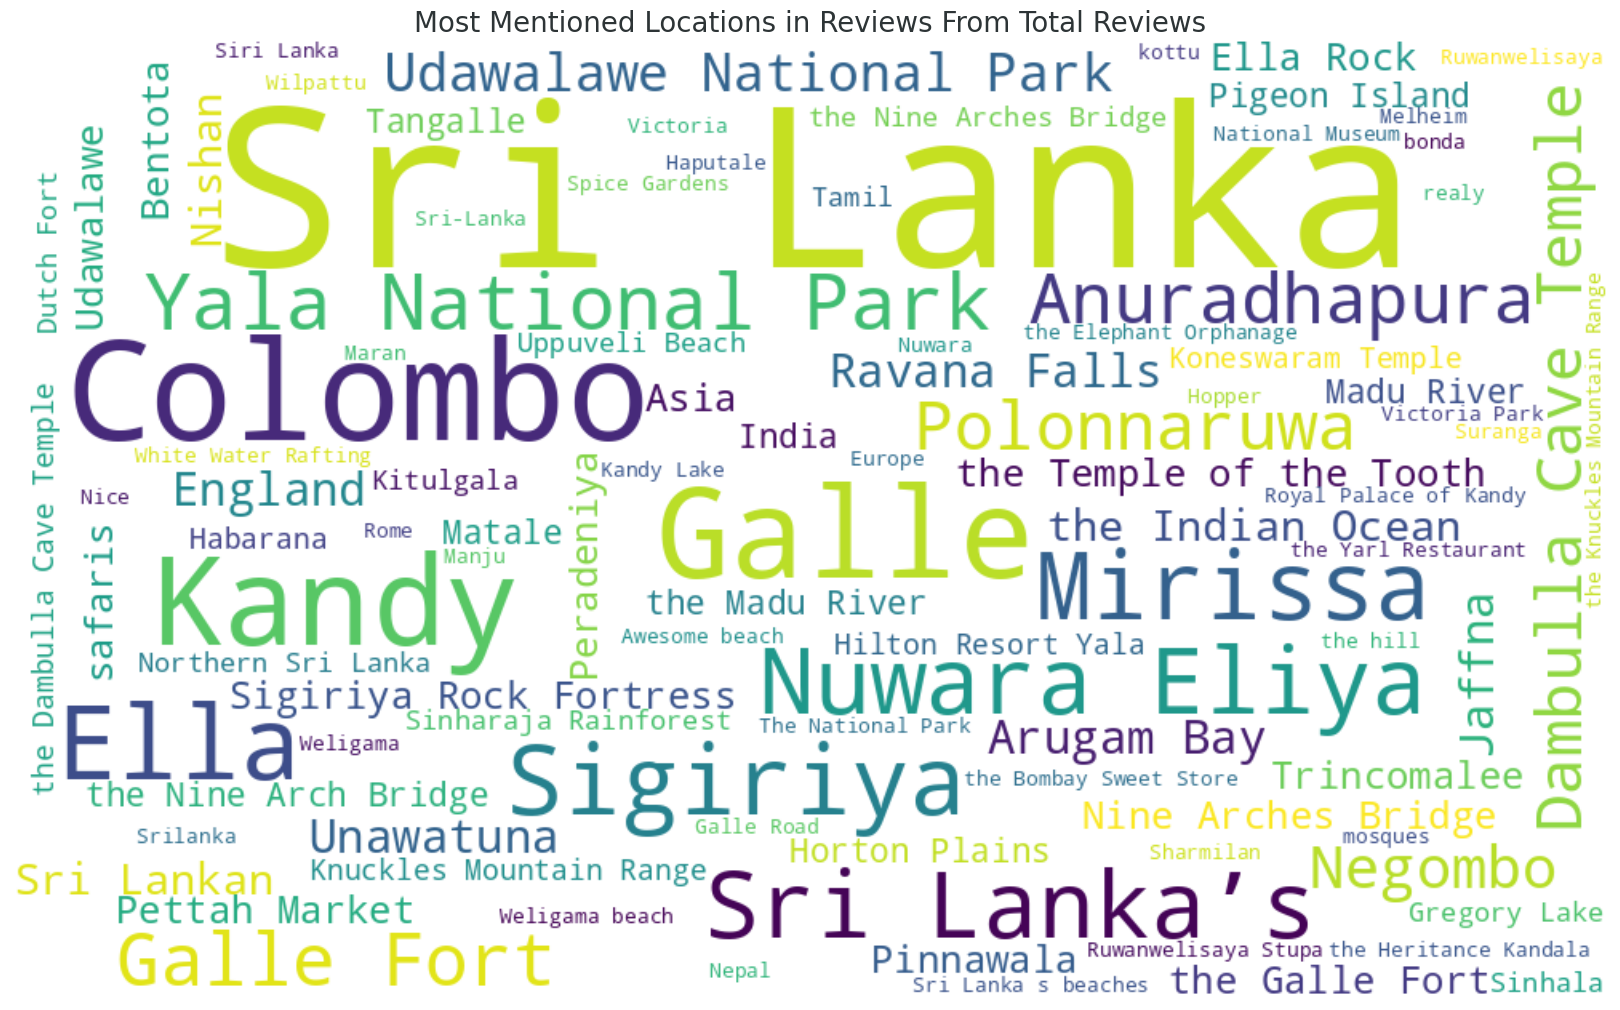

In [36]:
# Function to create a word cloud of most mentioned locations
def generate_location_wordcloud():
    # Flatten all extracted locations
    all_locations = []
    for locations in df['Extracted Locations']:
        all_locations.extend(locations)

    # Count frequency of each location
    location_counts = {}
    for location in all_locations:
        if location in location_counts:
            location_counts[location] += 1
        else:
            location_counts[location] = 1

    # Create word cloud
    wordcloud = WordCloud(
        width=1000,
        height=600,
        background_color='white',
        colormap='viridis',
        max_words=100,
        contour_width=1,
        contour_color='steelblue'
    ).generate_from_frequencies(location_counts)

    # Plot
    plt.figure(figsize=(16, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most Mentioned Locations in Reviews From Total Reviews', fontsize=20)
    plt.tight_layout(pad=0)

    return plt

# Generate the word cloud
location_wordcloud = generate_location_wordcloud()
location_wordcloud.show()

In [37]:
def plot_sentiment_distribution():
    # Create a Figure
    fig = go.Figure()

    # Define colors for sentiment categories
    positive_color = 'rgba(76, 175, 80, 0.7)'  # Attractive green
    neutral_color = 'rgba(255, 193, 7, 0.7)'   # Attractive yellow
    negative_color = 'rgba(244, 67, 54, 0.7)'  # Attractive red

    # Create separate traces for each sentiment category
    # Negative sentiment (-1 to -0.05)
    negative_df = df[df['Sentiment Score'] < -0.05]
    fig.add_trace(go.Histogram(
        x=negative_df['Sentiment Score'],
        nbinsx=10,
        marker_color=negative_color,
        opacity=0.8,
        name='Negative'
    ))

    # Neutral sentiment (-0.05 to 0.05)
    neutral_df = df[(df['Sentiment Score'] >= -0.05) & (df['Sentiment Score'] <= 0.05)]
    fig.add_trace(go.Histogram(
        x=neutral_df['Sentiment Score'],
        nbinsx=5,
        marker_color=neutral_color,
        opacity=0.8,
        name='Neutral'
    ))

    # Positive sentiment (0.05 to 1)
    positive_df = df[df['Sentiment Score'] > 0.05]
    fig.add_trace(go.Histogram(
        x=positive_df['Sentiment Score'],
        nbinsx=10,
        marker_color=positive_color,
        opacity=0.8,
        name='Positive'
    ))

    # Add vertical lines for sentiment categories
    fig.add_shape(
        type="line",
        x0=-0.05, y0=0, x1=-0.05, y1=df['Sentiment Score'].value_counts().max(),
        line=dict(color="black", width=2, dash="dash"),
        name="Negative Threshold"
    )

    fig.add_shape(
        type="line",
        x0=0.05, y0=0, x1=0.05, y1=df['Sentiment Score'].value_counts().max(),
        line=dict(color="black", width=2, dash="dash"),
        name="Positive Threshold"
    )

    # Add annotations
    fig.add_annotation(
        x=-0.5, y=df['Sentiment Score'].value_counts().max()*0.9,
        text="Negative",
        showarrow=False,
        font=dict(size=14, color=negative_color.replace('0.7', '1.0'))
    )

    fig.add_annotation(
        x=0, y=df['Sentiment Score'].value_counts().max()*0.9,
        text="Neutral",
        showarrow=False,
        font=dict(size=14, color=neutral_color.replace('0.7', '1.0'))
    )

    fig.add_annotation(
        x=0.5, y=df['Sentiment Score'].value_counts().max()*0.9,
        text="Positive",
        showarrow=False,
        font=dict(size=14, color=positive_color.replace('0.7', '1.0'))
    )

    # Update layout
    fig.update_layout(
        title="Distribution of Sentiment Scores for Total Reviews",
        xaxis_title="Sentiment Score",
        yaxis_title="Frequency",
        height=600,
        width=900,
        bargap=0.1,
        xaxis=dict(
            range=[-1, 1],
            tickmode='array',
            tickvals=[-1, -0.5, 0, 0.5, 1],
            ticktext=['-1 (Negative)', '-0.5', '0 (Neutral)', '0.5', '1 (Positive)']
        ),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        barmode='overlay'  # Overlay the histograms for a cleaner look
    )

    # Add overall statistics
    sentiment_counts = df['Sentiment Label'].value_counts()
    total = len(df)

    stats_text = f"<b>Sentiment Breakdown</b><br>"
    for label, count in sentiment_counts.items():
        percentage = (count / total) * 100
        color = positive_color if label == "Positive" else (neutral_color if label == "Neutral" else negative_color)
        stats_text += f"<span style='color:{color.replace('0.7', '1.0')}'>{label}: {count} ({percentage:.1f}%)</span><br>"

    fig.add_annotation(
        x=0.95, y=0.95,
        xref="paper", yref="paper",
        text=stats_text,
        showarrow=False,
        font=dict(size=12),
        align="right",
        bordercolor="black",
        borderwidth=1,
        borderpad=4,
        bgcolor="white",
        opacity=0.8
    )

    return fig

# Generate the sentiment distribution plot
sentiment_distribution_fig = plot_sentiment_distribution()
sentiment_distribution_fig.show()

In [38]:
# Function to visualize aspect categories distribution
def plot_aspect_categories():
    # Aspect categories from your code
    aspect_categories = {
        "attractions": ["beach", "temple", "heritage", "view", "scenery", "wildlife", "hiking", "mountain", "sigiriya",
                    "ella", "adams peak", "forest", "botanical garden", "park", "waterfall", "hot spring", "lighthouse"],
        "accommodation": ["hotel", "room", "stay", "resort", "hostel", "airbnb", "guesthouse", "villa", "bungalow"],
        "accessibility": ["road", "transportation", "traffic", "airport", "bus", "train", "taxi", "tuk-tuk", "cab"],
        "food": ["restaurant", "food", "meal", "cuisine", "breakfast", "dining", "buffet", "lunch", "dinner"],
        "safety": ["crime", "theft", "scam", "harassment", "accident", "security", "police"],
        "customer_service": ["staff", "hospitality", "service", "friendly", "rude", "helpful", "attitude"],
        "pricing": ["cost", "expensive", "affordable", "overpriced", "cheap", "value", "money", "budget"],
        "nightlife": ["bar", "pub", "club", "casino", "party", "music", "DJ", "live band", "karaoke"],
        "shopping": ["shopping", "market", "souvenirs", "mall", "crafts", "textile", "gemstones", "jewelry"],
        "culture": ["history", "tradition", "locals", "festival", "dance", "culture", "art", "ritual", "heritage"]
    }

    # Reverse mapping from aspect to category
    aspect_to_category = {}
    for category, aspects in aspect_categories.items():
        for aspect in aspects:
            aspect_to_category[aspect] = category

    # Count mentions of each category
    category_counts = {category: 0 for category in aspect_categories}

    for idx, row in df.iterrows():
        for aspect in row['Extracted Aspects']:
            if aspect in aspect_to_category:
                category = aspect_to_category[aspect]
                category_counts[category] += 1

    # Create DataFrame for plotting
    category_df = pd.DataFrame({
        'Category': list(category_counts.keys()),
        'Mentions': list(category_counts.values())
    })

    # Filter out categories with no mentions
    category_df = category_df[category_df['Mentions'] > 0]

    # Sort by mentions
    category_df = category_df.sort_values('Mentions', ascending=False)

    # Create pie chart
    fig = px.pie(
        category_df,
        values='Mentions',
        names='Category',
        title='Distribution of Aspect Categories in Total Reviews ',
        color_discrete_sequence=px.colors.qualitative.Pastel
    )

    fig.update_traces(
        textposition='inside',
        textinfo='percent+label',
        marker=dict(line=dict(color='#000000', width=1))
    )

    fig.update_layout(
        height=700,
        width=900
    )

    return fig

# Generate the aspect categories plot
aspect_categories_fig = plot_aspect_categories()
aspect_categories_fig.show()

In [40]:
# Function to create an interactive map of review locations
def create_interactive_map():
    # Sri Lanka coordinates
    sri_lanka_center = [7.8731, 80.7718]  # Latitude, Longitude

    # Define approximate coordinates for provinces and major cities
    # This is a simplified version - you would need to get exact coordinates
    location_coordinates = {
        # Provinces
        "Western Province": [6.9271, 79.8612],
        "Central Province": [7.2906, 80.6337],
        "Southern Province": [6.0535, 80.2210],
        "Northern Province": [9.0765, 80.2510],
        "Eastern Province": [7.7957, 81.5793],
        "North Western Province": [7.7501, 80.0750],
        "North Central Province": [8.3410, 80.5362],
        "Uva Province": [6.8991, 81.3545],
        "Sabaragamuwa Province": [6.7056, 80.3847],

        # Cities
        "Colombo": [6.9271, 79.8612],
        "Kandy": [7.2906, 80.6337],
        "Galle": [6.0535, 80.2210],
        "Jaffna": [9.6615, 80.0255],
        "Trincomalee": [8.5874, 81.2152],
        "Anuradhapura": [8.3410, 80.5362],
        "Negombo": [7.2095, 79.8369],
        "Nuwara Eliya": [6.9497, 80.7891],
        "Batticaloa": [7.7173, 81.7000],
        "Matara": [5.9549, 80.5550],
        "Matale": [7.4717, 80.6244],
        "Kurunegala": [7.4867, 80.3647],
        "Ratnapura": [6.7056, 80.3847],
        "Badulla": [6.9934, 81.0550],
        "Vavuniya": [8.7514, 80.4997],
        "Polonnaruwa": [7.9403, 81.0188],
        "Hambantota": [6.1429, 81.1212],
        "Kalutara": [6.5854, 79.9607],
        "Ella": [6.8667, 81.0466],
        "Mirissa": [5.9483, 80.4589],
        "Arugam Bay": [6.8448, 81.8310],
        "Sigiriya": [7.9572, 80.7533],
        "Tangalle": [6.0243, 80.7976],
        "Mannar": [9.0102, 79.8998]
    }

    # Calculate sentiment for each known location
    location_data = []

    for location, coords in location_coordinates.items():
        # Look for province sentiment
        if "Province" in location:
            province_reviews = df[df['Extracted Province'] == location]
            if len(province_reviews) > 0:
                avg_sentiment = province_reviews['Sentiment Score'].mean()
                count = len(province_reviews)
                location_data.append({
                    'name': location,
                    'lat': coords[0],
                    'lon': coords[1],
                    'sentiment': avg_sentiment,
                    'count': count,
                    'type': 'Province'
                })
        else:
            # For cities, check if they appear in extracted locations
            city_mentions = []
            for idx, row in df.iterrows():
                if any(location.lower() in loc.lower() for loc in row['Extracted Locations']):
                    city_mentions.append(row['Sentiment Score'])

            if city_mentions:
                avg_sentiment = sum(city_mentions) / len(city_mentions)
                location_data.append({
                    'name': location,
                    'lat': coords[0],
                    'lon': coords[1],
                    'sentiment': avg_sentiment,
                    'count': len(city_mentions),
                    'type': 'City'
                })

    # Create DataFrame for mapping
    map_df = pd.DataFrame(location_data)

    # Color scale based on sentiment
    color_scale = [
        [0, 'red'],        # -1 sentiment
        [0.5, 'yellow'],   # 0 sentiment
        [1, 'green']       # +1 sentiment
    ]

    # Normalize sentiment to 0-1 scale for coloring
    map_df['color_val'] = (map_df['sentiment'] + 1) / 2

    # Create map
    fig = px.scatter_mapbox(
        map_df,
        lat="lat",
        lon="lon",
        hover_name="name",
        hover_data=["sentiment", "count", "type"],
        color="color_val",
        color_continuous_scale=color_scale,
        size="count",
        size_max=20,
        zoom=7,
        center={"lat": sri_lanka_center[0], "lon": sri_lanka_center[1]},
        mapbox_style="carto-positron",
        title="Sentiment Map of Sri Lanka Tourism Locations"
    )

    # Update layout
    fig.update_layout(
        height=800,
        width=1000,
        coloraxis_colorbar=dict(
            title="Sentiment",
            tickvals=[0, 0.5, 1],
            ticktext=["-1 (Negative)", "0 (Neutral)", "+1 (Positive)"]
        )
    )

    return fig

# For mapbox functionality, you need a token:
import plotly.io as pio
# Uncomment and set your token if using Mapbox styles:
# pio.templates.default = "plotly"
# mapbox_access_token = "YOUR_MAPBOX_TOKEN"  # Replace with your token
# px.set_mapbox_access_token(mapbox_access_token)

# Generate the map (using default carto style which doesn't require a token)
interactive_map_fig = create_interactive_map()
interactive_map_fig.show()

In [41]:
# Function to analyze sentiment over time (if date information is available)
def analyze_sentiment_over_time():
    # Check if there's a date column in the original dataset
    # This is based on assumptions - you'll need to modify based on your actual data

    # For demonstration, let's create a synthetic date column
    # In a real scenario, you would use your actual date column from the original dataset

    # Let's assume we have 100 reviews spread over the last 12 months
    import datetime
    import random

    # Create a copy of the dataframe
    time_df = df.copy()

    # Generate random dates for the last 12 months
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=365)

    # Function to generate random dates
    def random_date(start, end):
        return start + datetime.timedelta(
            seconds=random.randint(0, int((end - start).total_seconds()))
        )

    # Add random dates
    time_df['Date'] = [random_date(start_date, end_date) for _ in range(len(time_df))]

    # Extract month-year
    time_df['Month-Year'] = time_df['Date'].dt.strftime('%b %Y')

    # Group by month and calculate average sentiment
    monthly_sentiment = time_df.groupby('Month-Year').agg({
        'Sentiment Score': 'mean',
        'Review': 'count'
    }).reset_index()

    # Sort by date
    monthly_sentiment['Sort_Date'] = pd.to_datetime(monthly_sentiment['Month-Year'], format='%b %Y')
    monthly_sentiment = monthly_sentiment.sort_values('Sort_Date')
    monthly_sentiment = monthly_sentiment.drop('Sort_Date', axis=1)

    # Create interactive line plot
    fig = px.line(
        monthly_sentiment,
        x='Month-Year',
        y='Sentiment Score',
        markers=True,
        title='Average Sentiment Score Over Time for Total Reviews',
        labels={'Sentiment Score': 'Average Sentiment', 'Month-Year': 'Month', 'Review': 'Number of Reviews'},
        hover_data=['Review']
    )

    # Add review count as bar chart
    fig.add_trace(
        go.Bar(
            x=monthly_sentiment['Month-Year'],
            y=monthly_sentiment['Review'],
            name='Review Count',
            yaxis='y2',
            marker_color='rgba(200, 200, 200, 0.6)'
        )
    )

    # Update layout for dual axis
    fig.update_layout(
        yaxis2=dict(
            title='Number of Reviews',
            overlaying='y',
            side='right'
        ),
        xaxis_title='Month',
        yaxis_title='Average Sentiment Score',
        height=600,
        width=1000,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )

    # Add horizontal line at 0 for neutral sentiment
    fig.add_shape(
        type="line",
        x0=0,
        y0=0,
        x1=len(monthly_sentiment) - 1,
        y1=0,
        line=dict(color="black", width=1, dash="dash")
    )

    return fig

# Generate the time analysis plot
sentiment_time_fig = analyze_sentiment_over_time()
sentiment_time_fig.show()

In [46]:
import pandas as pd
import plotly.graph_objects as go
from plotly.offline import plot

# Load the processed data
# Replace with your actual file path if different
df = pd.read_csv("/content/processed_reviews_Total.csv")

# Count sentiment labels
sentiment_counts = df['Sentiment Label'].value_counts()

# Define attractive colors for each sentiment
colors = {
    'Positive': '#2ecc71',  # Attractive green
    'Neutral': '#f1c40f',   # Attractive yellow
    'Negative': '#e74c3c'   # Attractive red
}

# Make sure all sentiment categories are present (with 0 if needed)
for sentiment in ['Positive', 'Neutral', 'Negative']:
    if sentiment not in sentiment_counts.index:
        sentiment_counts[sentiment] = 0

# Get values and colors in the right order
labels = ['Positive', 'Neutral', 'Negative']
values = [sentiment_counts.get(label, 0) for label in labels]
color_list = [colors[label] for label in labels]

# Calculate percentages for display
total = sum(values)
percentages = [f"{(value/total*100):.1f}%" if total > 0 else "0%" for value in values]

# Create hover text with count and percentage
hover_text = [f"{label}: {value} ({percent})" for label, value, percent in zip(labels, values, percentages)]

# Create the interactive pie chart
fig = go.Figure(data=[go.Pie(
    labels=labels,
    values=values,
    hole=0.4,
    marker=dict(colors=color_list),
    textinfo='label+percent',
    hoverinfo='text',
    hovertext=hover_text,
    textfont=dict(size=14),
    pull=[0.05, 0, 0],  # Slightly pull out the Positive slice
    rotation=90
)])

# Update layout with title and other properties
fig.update_layout(
    title={
        'text': 'Tourism Reviews Sentiment Distribution',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 24}
    },
    legend=dict(
        font=dict(size=16)
    ),
    annotations=[
        dict(
            text=f'Total Reviews: {total}',
            x=0.5,
            y=0.5,
            font=dict(size=16),
            showarrow=False
        )
    ]
)

# Display the figure
fig.show()